# Imports

In [1]:
import re
import string
from collections import Counter
from typing import List
from collections import defaultdict
import joblib
import random
import sys
import os

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import nltk
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import seaborn as sns



module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from components.common.text_preprocessing_lib import preprocess_single_text
from components.classification_model.model import FFNN

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rafaelkadyrov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rafaelkadyrov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rafaelkadyrov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Constants

In [3]:
RANDOM_SEED = 42
STOP_WORDS = nltk.corpus.stopwords.words("english")

# Setting random seed

In [4]:
torch.manual_seed(RANDOM_SEED)
np.random.seed()
random.seed()

# Functions

In [5]:
def plot_classes_distribution(labels_array: np.ndarray):
    classes, counts = np.unique(train_val_y, return_counts=True)
    
    plt.figure(figsize=(8, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.title('Classes distribution')
    plt.xlabel('Class name')
    plt.ylabel('Counts')
    plt.xticks(classes)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [6]:
def preprocess_corpus(corpus: List[str])->List[str]:
    return [preprocess_single_text(text) for text in corpus]

In [7]:
def simple_tokenizer(text):
    return text.lower().split()

In [8]:
def build_vocab(texts, min_freq=1):
    counter = Counter()
    for text in texts:
        tokens = simple_tokenizer(text)
        counter.update(tokens)
    vocab = {"<pad>": 0, "<unk>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# Data Preparation

In [9]:
train_val_split = fetch_20newsgroups(subset="train",
                                     data_home="../data/",
                                     remove=('headers', 'footers', 'quotes'),
                                     shuffle=False
                                    )
test_split = fetch_20newsgroups(subset="test",
                                data_home="../data/",
                                shuffle=False)
train_val_x, train_val_y = train_val_split.data, train_val_split.target
test_x, test_y = test_split.data, test_split.target

NUM_CLASSES = len(train_val_split.target_names)

In [10]:
train_x, val_x, train_y, val_y = train_test_split(train_val_x, train_val_y,
                                                  test_size=0.25,
                                                  random_state=RANDOM_SEED, stratify=train_val_y)

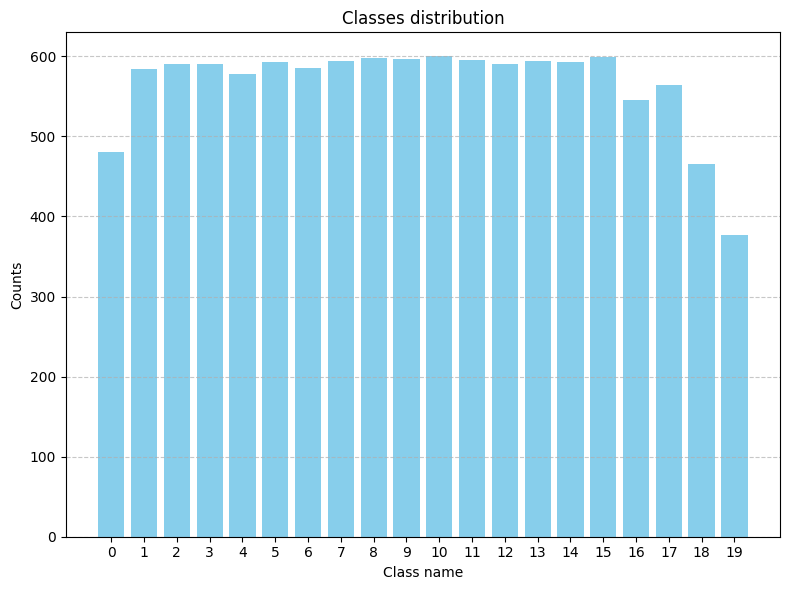

In [11]:
plot_classes_distribution(train_y)

# Model training

## Training simple model using sklearn

In [60]:
text_clf = Pipeline([
    ('vectorizer', TfidfVectorizer(preprocessor=preprocess_single_text)),
    ('classifier', MultinomialNB(alpha=.01))
])
text_clf.fit(train_x, train_y)

,steps,"[('vectorizer', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,<function pre...t 0x1196af240>
,tokenizer,None


In [61]:
f1_score(val_y, text_clf.predict(val_x), average="macro")

0.7459835495161714

## Training Pytorch FCN-based model with TF-IDF features

In [53]:
# feature_extractor = TfidfVectorizer(preprocessor=preprocess_single_text)
feature_extractor = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', use_idf=True, preprocessor=preprocess_single_text)

train_x_vectorized = feature_extractor.fit_transform(train_x).toarray()
val_x_vectorized = feature_extractor.transform(val_x).toarray()

joblib.dump(feature_extractor, "../models/tfidf_vectorizer.pkl")

['../models/tfidf_vectorizer.pkl']

In [54]:
train_x_vectorized.shape

(8485, 25013)

In [55]:
class TfidfDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [57]:
train_dataset = TfidfDataset(train_x_vectorized, train_y)
train_loader = DataLoader(train_dataset, batch_size=16)

val_dataset = TfidfDataset(val_x_vectorized, val_y)
val_loader = DataLoader(val_dataset, batch_size=16)

In [58]:
train_x_vectorized.shape

(8485, 25013)

In [59]:
EPOCHS_NUM = 20

In [60]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

criterion = nn.CrossEntropyLoss()

In [61]:
model_config = {
    "input_dim": train_x_vectorized.shape[1],
    "hidden_dim": 128,
    "output_dim": NUM_CLASSES
}

model = FFNN(**model_config)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0005)

history = defaultdict(list)

min_val_loss = float("inf")

for epoch in range(EPOCHS_NUM):
    print(f"Epoch {epoch}/{EPOCHS_NUM - 1}")
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss_value = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss_value.backward()
        optimizer.step()
        
        running_loss += loss_value.item() * inputs.size(0)
        
    model.eval()
    running_corrects = 0
    val_running_loss = 0.0
    TP = torch.zeros(NUM_CLASSES)
    FP = torch.zeros(NUM_CLASSES)
    FN = torch.zeros(NUM_CLASSES)
    
    for inputs, labels in tqdm(val_loader, desc="Validating"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        loss_value = criterion(outputs, labels)
        preds = preds.cpu()
        labels = labels.cpu()
        for cls in range(NUM_CLASSES):
            TP[cls] += ((preds == cls) & (labels == cls)).sum()
            FP[cls] += ((preds == cls) & (labels != cls)).sum()
            FN[cls] += ((preds != cls) & (labels == cls)).sum()
        running_corrects += torch.sum(preds == labels.data)
        val_running_loss += loss_value.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset)
    epoch_precision = TP / (TP + FP + 1e-8)
    epoch_recall = TP / (TP + FN + 1e-8)
    epoch_f1 = 2 * epoch_precision * epoch_recall / (epoch_precision + epoch_recall + 1e-8)
    epoch_f1_macro = epoch_f1.mean()
    epoch_precision_macro = epoch_precision.mean()
    epoch_recall_macro = epoch_recall.mean()
    print(f"Train loss {epoch_loss:.4f}, Val loss: {epoch_val_loss:.4f}, Val accuracy: {epoch_acc.item():.4f}, Val macro f1: {epoch_f1_macro:.4f}")
    print("-"*5)
    history["train_losses"].append(epoch_loss)
    history["val_losses"].append(epoch_val_loss)
    history["val_accuracy"].append(epoch_acc)
    history['val_precision_macro'].append(epoch_precision_macro)
    history['val_recall_macro'].append(epoch_recall_macro)
    history["val_f1_macro"].append(epoch_f1_macro)

    if epoch_val_loss < min_val_loss:
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'model_args': model_config
        }
        torch.save(checkpoint, '../models/best.pth')
        min_val_loss = epoch_val_loss
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_args': model_config
}
checkpoint.update(model_config)
torch.save(checkpoint, '../models/last.pth')

Epoch 0/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 355.98it/s]


Train loss 2.8509, Val loss: 2.5776, Val accuracy: 0.6158, Val macro f1: 0.5719
-----
Epoch 1/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 522.68it/s]


Train loss 2.2022, Val loss: 1.9352, Val accuracy: 0.6642, Val macro f1: 0.6131
-----
Epoch 2/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 451.44it/s]


Train loss 1.6195, Val loss: 1.5669, Val accuracy: 0.7017, Val macro f1: 0.6714
-----
Epoch 3/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 487.91it/s]


Train loss 1.2696, Val loss: 1.3655, Val accuracy: 0.7211, Val macro f1: 0.6971
-----
Epoch 4/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 443.10it/s]


Train loss 1.0509, Val loss: 1.2471, Val accuracy: 0.7303, Val macro f1: 0.7088
-----
Epoch 5/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 527.14it/s]


Train loss 0.9031, Val loss: 1.1728, Val accuracy: 0.7398, Val macro f1: 0.7226
-----
Epoch 6/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 473.16it/s]


Train loss 0.7964, Val loss: 1.1238, Val accuracy: 0.7409, Val macro f1: 0.7252
-----
Epoch 7/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 491.84it/s]


Train loss 0.7155, Val loss: 1.0898, Val accuracy: 0.7437, Val macro f1: 0.7304
-----
Epoch 8/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 459.78it/s]


Train loss 0.6517, Val loss: 1.0652, Val accuracy: 0.7437, Val macro f1: 0.7320
-----
Epoch 9/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 522.69it/s]


Train loss 0.5999, Val loss: 1.0468, Val accuracy: 0.7423, Val macro f1: 0.7313
-----
Epoch 10/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 494.58it/s]


Train loss 0.5570, Val loss: 1.0327, Val accuracy: 0.7437, Val macro f1: 0.7344
-----
Epoch 11/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 510.36it/s]


Train loss 0.5209, Val loss: 1.0215, Val accuracy: 0.7455, Val macro f1: 0.7372
-----
Epoch 12/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 508.13it/s]


Train loss 0.4903, Val loss: 1.0126, Val accuracy: 0.7455, Val macro f1: 0.7388
-----
Epoch 13/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 516.67it/s]


Train loss 0.4641, Val loss: 1.0053, Val accuracy: 0.7462, Val macro f1: 0.7401
-----
Epoch 14/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 515.99it/s]


Train loss 0.4416, Val loss: 0.9994, Val accuracy: 0.7462, Val macro f1: 0.7407
-----
Epoch 15/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 510.86it/s]


Train loss 0.4221, Val loss: 0.9945, Val accuracy: 0.7448, Val macro f1: 0.7393
-----
Epoch 16/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 516.51it/s]


Train loss 0.4052, Val loss: 0.9904, Val accuracy: 0.7444, Val macro f1: 0.7389
-----
Epoch 17/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 509.85it/s]


Train loss 0.3905, Val loss: 0.9870, Val accuracy: 0.7434, Val macro f1: 0.7378
-----
Epoch 18/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 514.11it/s]


Train loss 0.3776, Val loss: 0.9842, Val accuracy: 0.7451, Val macro f1: 0.7398
-----
Epoch 19/19


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 502.63it/s]

Train loss 0.3664, Val loss: 0.9817, Val accuracy: 0.7455, Val macro f1: 0.7402
-----


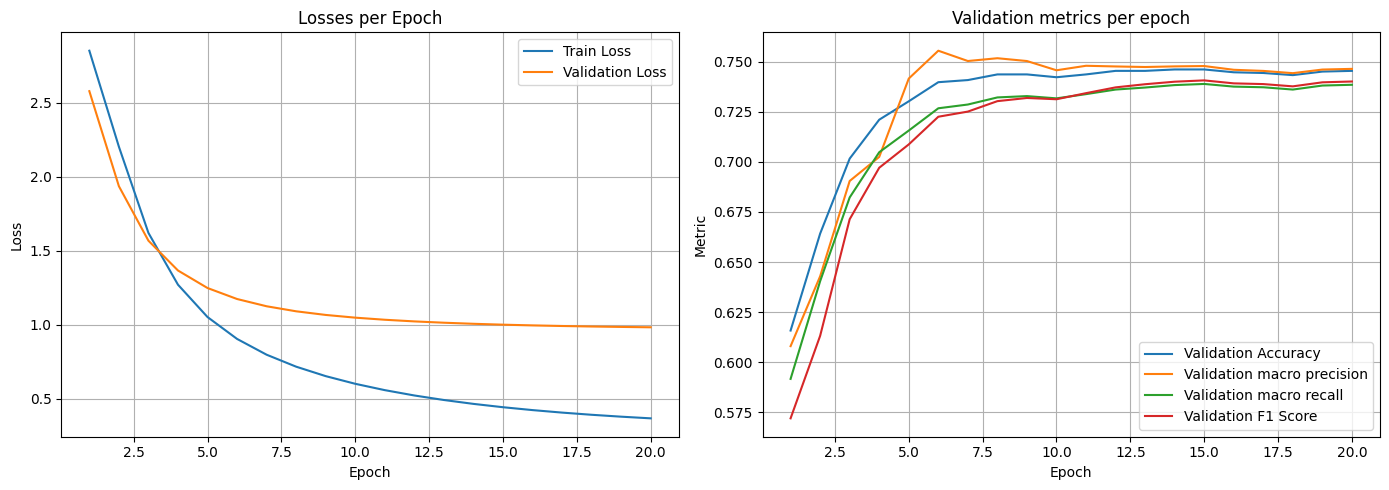

In [67]:
plt.figure(figsize=(14, 5))

epochs = range(1, len(history['train_losses']) + 1)

# График лоссов
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses per Epoch')
plt.legend()
plt.grid(True)

# График accuracy и F1
plt.subplot(1, 2, 2)
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, history['val_precision_macro'], label='Validation macro precision')
plt.plot(epochs, history['val_recall_macro'], label='Validation macro recall')
plt.plot(epochs, history['val_f1_macro'], label='Validation F1 Score')

plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Validation metrics per epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Validating and testing best model

In [63]:
model_checkpoint = torch.load("../models/best.pth")
model_args = model_checkpoint["model_args"]

model = FFNN(**model_args).to(device)

model.load_state_dict(model_checkpoint['model_state_dict'])

model.eval()

all_preds = []
all_labels = []

for inputs, labels in tqdm(val_loader, desc="Validating"):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    loss_value = criterion(outputs, labels)
    all_preds.extend(list(preds.cpu().numpy()))
    all_labels.extend(list(labels.cpu().numpy()))

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")
print(f"Val accuracy: {accuracy:.4f}, Val macro precision: {precision:.4f}, Val macro recall: {recall:.4f}  Val macro f1: {f1:.4f}")


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 277.99it/s]


Val accuracy: 0.7455, Val macro precision: 0.7465, Val macro recall: 0.7385  Val macro f1: 0.7402


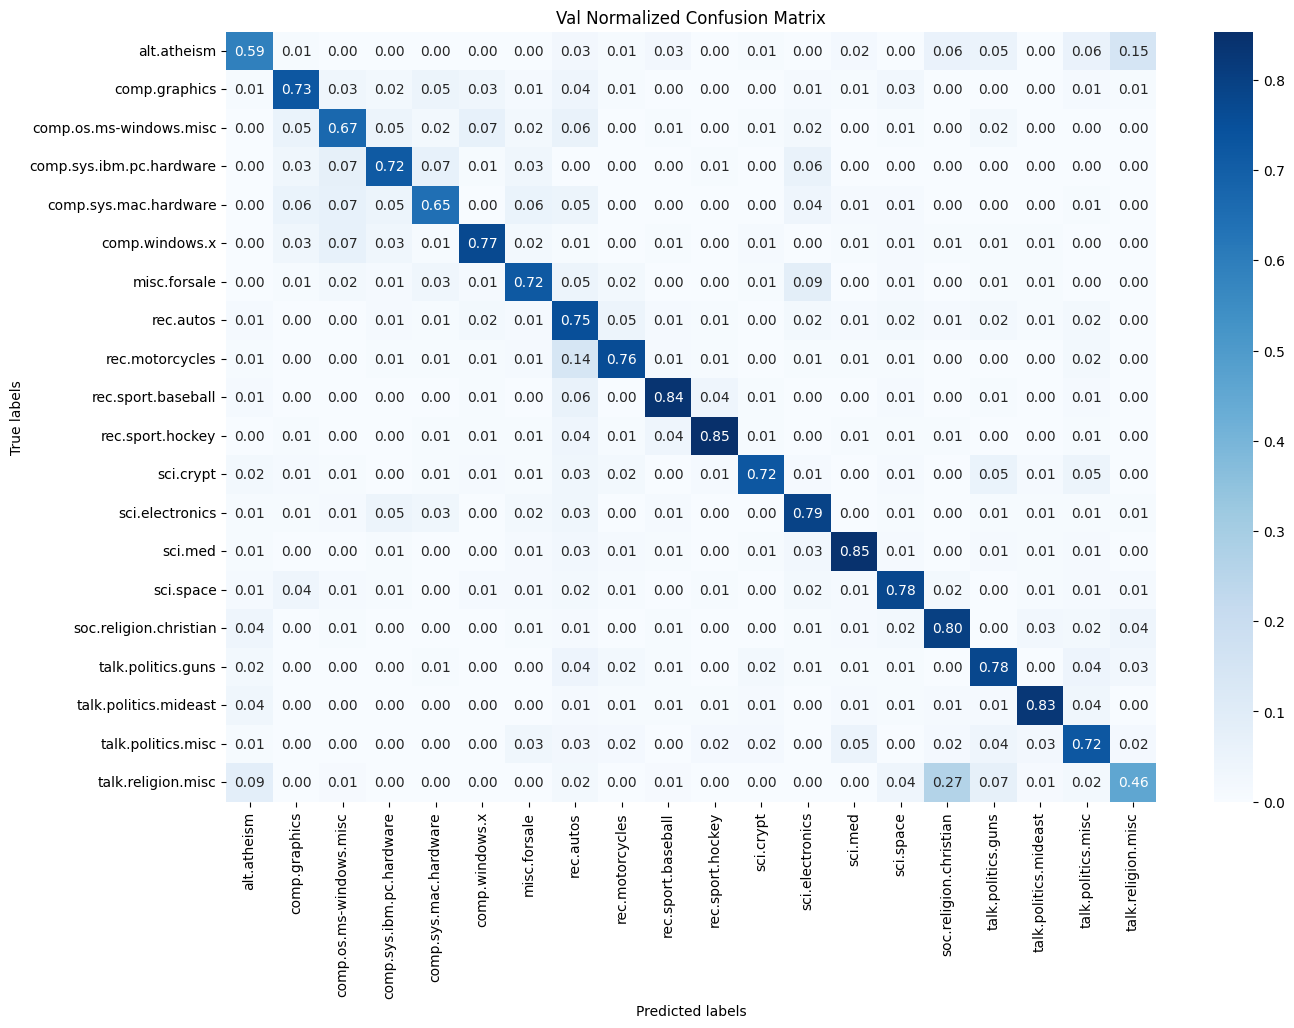

In [64]:
cm = confusion_matrix(all_labels, all_preds, normalize="true")

plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=train_val_split.target_names, yticklabels=train_val_split.target_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Val Normalized Confusion Matrix')
plt.show()

In [65]:
model_checkpoint = torch.load("../models/best.pth")
model_args = model_checkpoint["model_args"]

model = FFNN(**model_args).to(device)

model.load_state_dict(model_checkpoint['model_state_dict'])

test_x_vectorized = feature_extractor.transform(test_x).toarray()
test_dataset = TfidfDataset(test_x_vectorized, test_y)
test_loader = DataLoader(test_dataset, batch_size=16)

model.eval()

all_preds = []
all_labels = []

for inputs, labels in tqdm(test_loader, desc="Testing"):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    loss_value = criterion(outputs, labels)
    all_preds.extend(list(preds.cpu().numpy()))
    all_labels.extend(list(labels.cpu().numpy()))

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")
print(f"Test accuracy: {accuracy:.4f}, Test macro precision: {precision:.4f}, Test macro recall: {recall:.4f}  Test macro f1: {f1:.4f}")


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 471/471 [00:01<00:00, 255.72it/s]

Test accuracy: 0.7811, Test macro precision: 0.7859, Test macro recall: 0.7692  Test macro f1: 0.7715


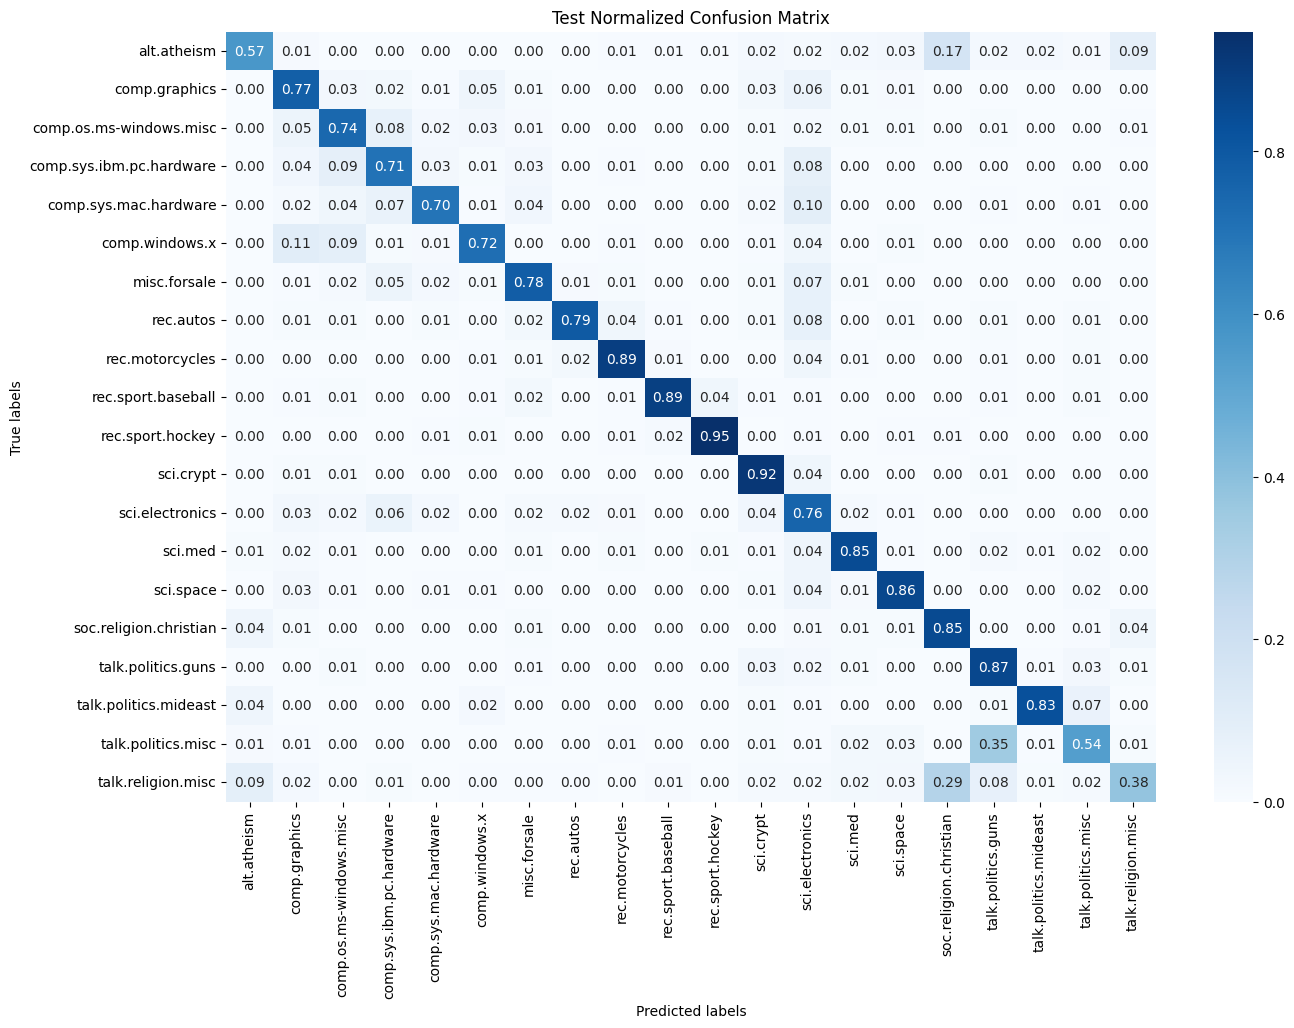

In [66]:
cm = confusion_matrix(all_labels, all_preds, normalize="true")

plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=train_val_split.target_names, yticklabels=train_val_split.target_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Test Normalized Confusion Matrix')
plt.show()

In [52]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

8485 2829 7532


## Training Pytorch LSTM-based model

In [155]:
preprocessed_train_x = preprocess_corpus(train_x)
preprocessed_val_x = preprocess_corpus(val_x)

In [156]:
vocab = build_vocab(preprocessed_train_x)

In [157]:
len(vocab)

67101

In [216]:
class CorpusDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=64):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def encode(self, text):
        tokens = simple_tokenizer(text)
        ids = [self.vocab.get(token, self.vocab["<unk>"]) for token in tokens][:self.max_len]
        ids += [self.vocab["<pad>"]] * (self.max_len - len(ids))
        return torch.tensor(ids)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.encode(self.texts[idx]), torch.tensor(self.labels[idx])

In [217]:
train_dataset = CorpusDataset(preprocessed_train_x, train_y, vocab)
val_dataset = CorpusDataset(preprocessed_val_x, val_y, vocab)

train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

In [223]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])

In [ ]:
EPOCHS_NUM = 20

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = TextClassifier(len(vocab), embed_dim=128, hidden_dim=128, output_dim=NUM_CLASSES)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

history = defaultdict(list)

for epoch in range(EPOCHS_NUM):
    print(f"Epoch {epoch}/{EPOCHS_NUM - 1}")
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss_value = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss_value.backward()
        optimizer.step()
        
        running_loss += loss_value.item() * inputs.size(0)
        
    model.eval()
    running_corrects = 0
    val_running_loss = 0.0
    TP = torch.zeros(NUM_CLASSES)
    FP = torch.zeros(NUM_CLASSES)
    FN = torch.zeros(NUM_CLASSES)
    
    for inputs, labels in tqdm(val_loader, desc="Validating"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        loss_value = criterion(outputs, labels)
        preds = preds.cpu()
        labels = labels.cpu()
        for cls in range(NUM_CLASSES):
            TP[cls] += ((preds == cls) & (labels == cls)).sum()
            FP[cls] += ((preds == cls) & (labels != cls)).sum()
            FN[cls] += ((preds != cls) & (labels == cls)).sum()
        running_corrects += torch.sum(preds == labels.data)
        val_running_loss += loss_value.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset)
    epoch_precision = TP / (TP + FP + 1e-8)
    epoch_recall = TP / (TP + FN + 1e-8)
    epoch_f1 = 2 * epoch_precision * epoch_recall / (epoch_precision + epoch_recall + 1e-8)
    epoch_f1_macro = epoch_f1.mean()
    print(f"Train loss {epoch_loss:.4f}, Val loss: {epoch_val_loss:.4f}, Val accuracy: {epoch_acc.item():.4f}, Val macro f1: {epoch_f1_macro:.4f}")
    print("-"*5)
    history["train_losses"].append(epoch_loss)
    history["val_losses"].append(epoch_val_loss)
    history["val_accuracy"].append(epoch_acc)
    history["val_f1_macro"].append(epoch_f1_macro)
    

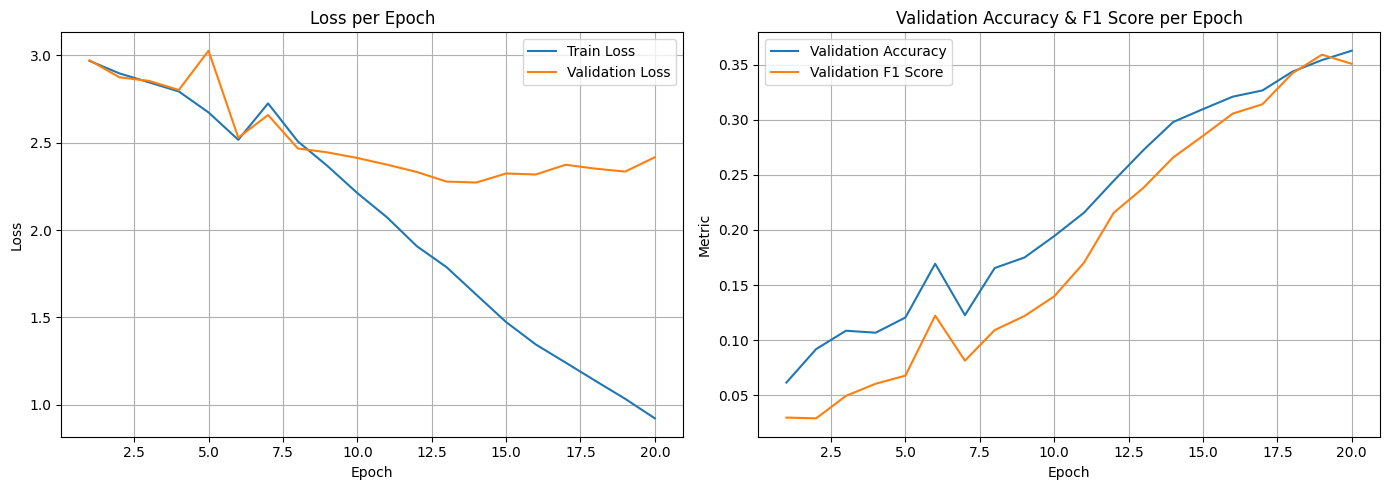

In [226]:
plt.figure(figsize=(14, 5))

epochs = range(1, len(history['train_losses']) + 1)

# График лоссов
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

# График accuracy и F1
plt.subplot(1, 2, 2)
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, history['val_f1_macro'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Validation Accuracy & F1 Score per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [198]:
values = []
for text in train_x:
    tokens = simple_tokenizer(text)
    values.append(len(tokens))

In [209]:
np.median(values)

np.float64(83.0)